# Visualizing a NetworkX graph in the Notebook with D3.js

In [63]:
import json
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

load gml file produced from Flashweave script

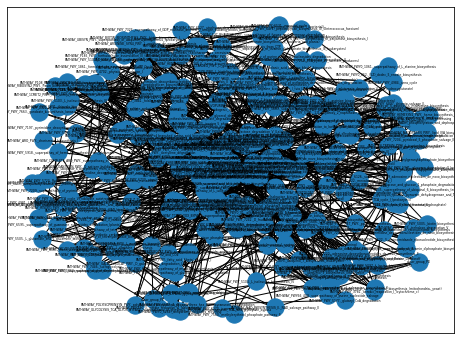

In [64]:
g = nx.read_weighted_edgelist('data/Co_Abundance_Analysis/pathways_network_output.edgelist')
fig, ax = plt.subplots(1, 1, figsize=(8, 6));
nx.draw_networkx(g, ax=ax, with_labels=True, font_size = 3)

load additional metadata specifying node colors

In [65]:
g_colors = pd.read_csv('files/flashweave_metadata_pathways_network_colors.csv')
g_colors["count_alias"] = list(range(len(g_colors)))
g_colors.head()

,Unnamed: 0,Node,group,group_color,count_alias
0,1,PATHWAY_1CMET2_PWY._N10_formyl_tetrahydrofolat...,None,#c7c7c7,0
1,2,PATHWAY_ANAEROFRUCAT_PWY._homolactic_fermentation,Down_PDvHC,#1f77b4,1
2,3,PATHWAY_ANAGLYCOLYSIS_PWY._glycolysis_III_(fro...,None,#c7c7c7,2
3,4,PATHWAY_ARG+POLYAMINE_SYN._superpathway_of_arg...,None,#c7c7c7,3
4,5,PATHWAY_ARGDEG_PWY._superpathway_of_L_arginine...,None,#c7c7c7,4


# Convert graphical data to Javascript by exporting dictionaries with JSON:
D3.js expects each edge to be an object with a source and target. 
Also, we specify which side each member has taken (code attribute):


In [66]:
nodes = [{'name': str(g_colors.count_alias[col]), 
          "long_name" : str(g_colors.Node[i]),
          'group': g_colors.group[i],
          'group_color' : str(g_colors.group_color[i])}
         for i, col in enumerate(g_colors.count_alias)]

links = [{'source': int(g_colors.loc[g_colors["Node"] == u[0], "count_alias"]),
          'target':  int(g_colors.loc[g_colors["Node"] == u[1], "count_alias"]),
          'weight': g.get_edge_data(u[0], u[1])['weight']}
         for u in g.edges()]

with open('flashweave_graph_pathways.json', 'w') as f:
    json.dump({'nodes': nodes, 'links': links},
              f, indent=4,)

In [67]:
# links

In [68]:
%%javascript
// We load the d3.js library from the Web.
require.config({paths:
    {d3: "http://d3js.org/d3.v3.min"}});
// require.config({paths:
//     {cola: "http://marvl.infotech.monash.edu/webcola/cola.v3.min"}});

<IPython.core.display.Javascript object>

In [69]:
%%html
<div id="d3-panel"></div>
<style>
.node {stroke: #fff; stroke-width: 1.5px;}
.link {stroke: #999; stroke-opacity: .6;}
</style>

In [61]:
%%javascript

require(["d3"], function(d3) {
  // The code in this block is executed when the d3.js library has been loaded.
  // First, we specify the size of the canvas containing the visualization (size of the <div> element).
  var width = 700, height = 700;
  // We create a color scale.
//   var color = d3.scale.category10();
  // In the <div> element, we create a <svg> graphic that will contain our interactive visualization.
  var svg = d3.select("#d3-panel").select("svg")
  if (svg.empty()) {
    svg = d3.select("#d3-panel").append("svg")
          .attr("width", width)
          .attr("height", height);
  }

  // We load the JSON file.
  d3.json("flashweave_graph_pathways.json", function(error, graph) {
    // In this block, the file has been loaded and the 'graph' object contains our graph.
      
      //Extract data from dataset
    var nodes = graph.nodes,
        links = graph.links;
      
//     // We create a force-directed dynamic graph layout.
//     var force = d3.layout.force()
//         .size([width, height])
//         .nodes(nodes)
//         .links(links)
//         .gravity(0.2)
//         .charge(-80)
//         .linkDistance(30)
//         .start();
      
    var force = d3.forceSimulation()
    // pull nodes together based on the links between them
        .force("link", d3.forceLink()
            .id(function(d) {
                return d.weight;
        })
        .strength(function(d) {
            return linkStrengthScale(d.weight);
        }))
        // push nodes apart to space them out
        .force("charge", d3.forceManyBody()
        .strength(-200))
        // add some collision detection so they don't overlap
        .force("collide", d3.forceCollide()
        .radius(30))
        // and draw them around the centre of the space
        .force("center", d3.forceCenter(width / 2, height / 2));

      
    // We create a <line> SVG element for each link in the graph.
    var link = svg.selectAll(".link")
      .data(links)
      .enter()
      .append("line")
      .attr("stroke-width", function(d){ return d.weight*2; })
      .attr("class", "link");

    // We create a <circle> SVG element for each node in the graph, and we specify a few attributes.
    var node = svg.selectAll(".node")
      .data(nodes)
      .enter()
      .append("circle")
      .attr("class", "node")
      .attr("r", 5)  // radius
//       .style("fill", function(d) {
//          return color(d.group); })
      .style("fill", function(d) { return d.group_color; })
      .call(force.drag);

    // The name of each node is the node number.
    node.append("title")
        .text(function(d) { return d.long_name; });

    // We bind the positions of the SVG elements
    // to the positions of the dynamic force-directed
    // graph, at each time step.
    force.on("tick", function() {
      link.attr("x1", function(d){return d.source.x})
          .attr("y1", function(d){return d.source.y})
          .attr("x2", function(d){return d.target.x})
          .attr("y2", function(d){return d.target.y});

      node.attr("cx", function(d){return d.x})
          .attr("cy", function(d){return d.y});
    });
  });
});

<IPython.core.display.Javascript object>

In [70]:
%%javascript

require(["d3"], function(d3) {
  // The code in this block is executed when the d3.js library has been loaded.
  // First, we specify the size of the canvas containing the visualization (size of the <div> element).
  var width = 700, height = 700;
  // We create a color scale.
//   var color = d3.scale.category10();
  // In the <div> element, we create a <svg> graphic that will contain our interactive visualization.
  var svg = d3.select("#d3-panel").select("svg")
  if (svg.empty()) {
    svg = d3.select("#d3-panel").append("svg")
          .attr("width", width)
          .attr("height", height);
  }

  // We load the JSON file.
  d3.json("flashweave_graph_pathways.json", function(error, graph) {
    // In this block, the file has been loaded and the 'graph' object contains our graph.
      
      //Extract data from dataset
    var nodes = graph.nodes,
        links = graph.links;
      
    // We create a force-directed dynamic graph layout.
    var force = d3.layout.force()
        .size([width, height])
        .nodes(nodes)
        .links(links)
        .gravity(0.2)
        .charge(-80)
        .linkDistance(30)
        .start();

      
    // We create a <line> SVG element for each link in the graph.
    var link = svg.selectAll(".link")
      .data(links)
      .enter()
      .append("line")
      .attr("stroke-width", function(d){ return d.weight*2; })
      .attr("class", "link");

    // We create a <circle> SVG element for each node in the graph, and we specify a few attributes.
    var node = svg.selectAll(".node")
      .data(nodes)
      .enter()
      .append("circle")
      .attr("class", "node")
      .attr("r", 5)  // radius
//       .style("fill", function(d) {
//          return color(d.group); })
      .style("fill", function(d) { return d.group_color; })
      .call(force.drag);

    // The name of each node is the node number.
    node.append("title")
        .text(function(d) { return d.long_name; });

    // We bind the positions of the SVG elements
    // to the positions of the dynamic force-directed
    // graph, at each time step.
    force.on("tick", function() {
      link.attr("x1", function(d){return d.source.x})
          .attr("y1", function(d){return d.source.y})
          .attr("x2", function(d){return d.target.x})
          .attr("y2", function(d){return d.target.y});

      node.attr("cx", function(d){return d.x})
          .attr("cy", function(d){return d.y});
    });
  });
});

<IPython.core.display.Javascript object>

## Curved and weighted edge attempt - doesn't work: https://bl.ocks.org/martinjc/e4c013dab1fabb2e02e2ee3bc6e1b49d

In [ ]:
%%javascript

require(["d3"], function(d3) {
  // The code in this block is executed when the d3.js library has been loaded.
  var width = 700, height = 700;
  var margin = {
    top: 50,
    bottom: 50,
    left: 50,
    right: 50, }
  
  // In the <div> element, we create a <svg> graphic that will contain our interactive visualization.
  var svg = d3.select("#d3-panel").select("svg")
  if (svg.empty()) {
    svg = d3.select("#d3-panel").append("svg")
          .attr("width", width)
          .attr("height", height)
          .attr('transform', 'translate(' + margin.top + ',' + margin.left + ')'); }
    
  width = width - margin.left - margin.right;
  height = height - margin.top - margin.bottom;
    
  var linkWidthScale = d3.scaleLinear()
    .domain([-1, 1])
    .range([-15, 15]);
  var linkStrengthScale = d3.scaleLinear()
    .range([0, 0.45]);
    
  var simulation = d3.forceSimulation()
    // pull nodes together based on the links between them
    .force("link", d3.forceLink()
        .id(function(d) {
            return d.name;
        })
        .strength(function(d) {
            return linkStrengthScale(d.weight);
        }))
    // push nodes apart to space them out
    .force("charge", d3.forceManyBody()
        .strength(-200))
    // add some collision detection so they don't overlap
    .force("collide", d3.forceCollide()
        .radius(30))
    // and draw them around the centre of the space
    .force("center", d3.forceCenter(width / 2, height / 2));
    

  // We load the JSON file.
  d3.json("flashweave_graph_pathways.json", function(error, graph) {
    //Extract data from dataset
    var nodes = graph.nodes,
        links = graph.links;
      
    linkWidthScale.domain(d3.extent(links, function(d) {
        return d.weight;
    }));
    linkStrengthScale.domain(d3.extent(links, function(d) {
        return d.weight;
    }));

    // We create a <line> SVG element for each link in the graph.
    var link = svg.selectAll(".link")
      .data(links)
      .enter()
      .append("path")
      .attr("class", "link")
      .attr('stroke', function(d) {return "#ddd"; })
      .attr('stroke-width', function(d) { return linkWidthScale(d.weight); });
      
    // add the nodes to the graphic
    var node = svg.selectAll(".node")
        .data(nodes)
        .enter()
        .append("g")

    // a circle to represent the node
    node.append("circle")
        .attr("class", "node")
        .attr("r", 5)
        .attr("fill", function(d) {
            return d.group_color;
        })
        .on("mouseover", mouseOver(.1))
        .on("mouseout", mouseOut);

    // hover text for the node
    node.append("title")
        .text(function(d) {
            return d.long_name;
        });

    // add a label to each node
    node.append("text")
        .attr("dx", 12)
        .attr("dy", ".35em")
        .text(function(d) {
            return d.long_name;
        })
        .style("stroke", "black")
        .style("stroke-width", 0.5)
        .style("fill", function(d) {
            return d.group_color;
        });

    // add the nodes to the simulation and
    // tell it what to do on each tick
    simulation
        .nodes(nodes)
        .on("tick", ticked);
    // add the links to the simulation
    simulation
        .force("link")
        .links(links);
    // on each tick, update node and link positions
    function ticked() {
        link.attr("d", positionLink);
        node.attr("transform", positionNode);
    }

    // move the node based on forces calculations
    function positionNode(d) {
        // keep the node within the boundaries of the svg
        if (d.x < 0) {
            d.x = 0  };
        if (d.y < 0) {
            d.y = 0  };
        if (d.x > width) {
            d.x = width  };
        if (d.y > height) {
            d.y = height  };
        return "translate(" + d.x + "," + d.y + ")";
    }

    // build a dictionary of nodes that are linked
    var linkedByIndex = {};
    links.forEach(function(d) {
        linkedByIndex[d.source.index + "," + d.target.index] = 1;
    });

    // check the dictionary to see if nodes are linked
    function isConnected(a, b) {
        return linkedByIndex[a.index + "," + b.index] || linkedByIndex[b.index + "," + a.index] || a.index == b.index;
    }
      
    // fade nodes on hover
    function mouseOver(opacity) {
        return function(d) {
            // check all other nodes to see if they're connected
            // to this one. if so, keep the opacity at 1, otherwise
            // fade
            node.style("stroke-opacity", function(o) {
                thisOpacity = isConnected(d, o) ? 1 : opacity;
                return thisOpacity;
            });
            node.style("fill-opacity", function(o) {
                thisOpacity = isConnected(d, o) ? 1 : opacity;
                return thisOpacity;
            });
            // also style link accordingly
            link.style("stroke-opacity", function(o) {
                return o.source === d || o.target === d ? 1 : opacity;
            });
            link.style("stroke", function(o) {
                return o.source === d || o.target === d ? o.source.colour : "#ddd";
            });
        };
    }

     function mouseOut() {
         node.style("stroke-opacity", 1);
         node.style("fill-opacity", 1);
         link.style("stroke-opacity", 1);
         link.style("stroke", "#ddd");
     } 
      
      
      

  });
});